In [1]:
import pandas as pd
import numpy as np
import gzip
import os
import datetime
import pandas as pd
import calendar
import numpy as np
import glob
import sys
import gc
import re
#import quantstats as qs
import time

import matplotlib.pyplot as plt

import nest_asyncio # install this package to avoid running in loop

import urllib
import pandas_ta as ta

import warnings

import requests

import hmac
import hashlib

import aiohttp
import asyncio

import logging
from datetime import timezone

import nest_asyncio

# Filter depreciation warnings from pandas regarding the append method
warnings.filterwarnings('ignore', category=FutureWarning, message=".*append.*")
pd.options.mode.chained_assignment = None

# Set pandas to display all digits for floating-point numbers
pd.options.display.float_format = '{:.8f}'.format

import os
from dotenv import load_dotenv

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Ignore only FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Ignore only RuntimeWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

import importlib


from Orats_options_fetch_functions import *

from faster_numba_strategy_functions import *

import strategy_functions

importlib.reload(strategy_functions)
from strategy_functions import *

# import Common_functions

# importlib.reload(strategy_functions)
# importlib.reload(Common_functions)

# from Common_functions import *
# coin_desk_api_key =  "e43c1fd991e660b9bf959645f0800bb7e76fb4a3537ab773cec62b2fad31af2d"
from datetime import time
from pathlib import Path
# Get the user's home directory dynamically
home_dir = r"C:\Data\Options_logs"
#====================================

strategy_name = "Backtest_v1"

# Create a folder for the strategy_name if it doesn't exist in home directory

strategy_folder = os.path.join(home_dir, strategy_name)
if not os.path.exists(strategy_folder):
    os.makedirs(strategy_folder)

# Create the full path to the output file. this file contains all the trades

output_all_trades_file = os.path.join(strategy_folder, f"All_trades_{strategy_name}.csv")
trade_html_file = os.path.join(strategy_folder, f"Trade_stats_{strategy_name}.html")

#=== location to store the trade dataframe for debug

base_folder_df = "strategy_dataframe"
df_folder = os.path.join(strategy_folder, base_folder_df)
if not os.path.exists(df_folder):
    os.makedirs(df_folder)
    print("\n Created strategy dataframe folder : " ,df_folder )

#----- symbol_wise_trades

trades_folder = "sym_wise_trades"
trades_strategy_folder = os.path.join(strategy_folder, trades_folder)

if not os.path.exists(trades_strategy_folder):
    print("\n Making folder for symbol wise trades of strategy" , trades_strategy_folder)
    os.makedirs(trades_strategy_folder)

logger = setup_logger("Straddle_0DTE", strategy_folder, log_file="strategy.log" , to_console=False)


In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Connect to an in-memory database
con = duckdb.connect()

# --- Your setup code (which is correct) ---
con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")
con.execute("""
SET s3_endpoint='122.176.133.73:9000';
SET s3_use_ssl=false;
SET s3_access_key_id='minioadmin';
SET s3_secret_access_key='minioadmin';
""")
con.execute("SET s3_url_style='path';") 
con.execute("PRAGMA threads=8;")
con.execute("PRAGMA enable_object_cache;")

# --- THE MISSING STEP: Querying a file from S3 ---
# Replace with your actual S3 bucket and file path
# This can be a .parquet, .csv, or .json file
s3_file_path = 's3://duckdata/ORATS/Options/**/*.parquet'

try:
    # Execute a query on the S3 file and fetch the result as a Pandas DataFrame
    print(f"Querying data from: {s3_file_path}")
    df = con.execute(f"""
        SELECT *
        FROM '{s3_file_path}'
        LIMIT 2;
    """).df()

    print("\n✅ Query successful! First 5 rows of data:")
    print(df.head())

except Exception as e:
    print(f"\n❌ An error occurred during the query: {e}")

# finally:
#     # It's good practice to close the connection
#     con.close()

Querying data from: s3://duckdata/ORATS/Options/**/*.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


✅ Query successful! First 5 rows of data:
      expiry       strike  dte  optionType                  ts         low  \
0 2024-01-26 421.00000000   25          -1 2024-01-02 17:13:00 17.18000000   
1 2024-01-12 414.00000000   11          -1 2024-01-02 17:13:00 10.41500000   

         high        open       close     volume  ...      askSize  \
0 17.18000000 17.18000000 17.18000000 0.00000000  ...  50.00000000   
1 10.41500000 10.41500000 10.41500000 0.00000000  ... 151.00000000   

     bidPrice    askPrice      bidIv      askIv         iv          oi  \
0 17.12000000 17.24000000 0.13785700 0.14511500 0.14148600 15.00000000   
1 10.34000000 10.49000000 0.14267100 0.15199600 0.14733300 54.00000000   

    stockPrice        day ticker  
0 404.00000000 2024-01-02    QQQ  
1 404.00000000 2024-01-02    QQQ  

[2 rows x 21 columns]


In [3]:


ifol = r"C:\Data\Aggregate_Data\Options\USA\Raw_SPY_1min_2024_2025_ORATS_close.parquet"
#== read the RELIANCE data

com_df2 = pd.read_parquet(ifol)

if 'timestamp' in com_df2.columns:
    com_df2['timestamp'] = pd.to_datetime(com_df2['timestamp'])
    com_df2.set_index('timestamp', inplace=True)



com_df2 = com_df2[~com_df2.index.duplicated(keep='first')]


com_df2.dropna(how='all', inplace=True)

vix_df = pd.read_parquet(r"C:\Data\Aggregate_Data\VIX_1_min_2019_2025.parquet")
com_df2 = com_df2.join(vix_df)


final_symbols = com_df2.filter(like='close').columns.str.replace('_close', '')
print("Total symbols found after all filtering: ", len(final_symbols))

# Calculate the number of rows in the DataFrame

com_df2[[f"{symbol}_intraday_low" for symbol in final_symbols]] =com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: intraday_low(com_df2, low_col=x.name,agg_func='min'))

com_df2[[f"{symbol}_intraday_high" for symbol in final_symbols]] =com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: intraday_high(com_df2, high_col=x.name,agg_func='max'))

com_df2[[f"{symbol}_todayo" for symbol in final_symbols]] = com_df2[[f'{symbol}_close' for symbol in final_symbols]].resample('D').transform('first')

# com_df2[[f"{symbol}_daily_ROC" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change(periods=50)

# com_df2[[f"{symbol}_ROC" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change()

# com_df2[[f"{symbol}_ROC_4" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change(periods=4)

com_df2[[f"{symbol}_prevdayl" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: get_x_day_low_numba(com_df2, n=1, column=x.name))

com_df2[[f"{symbol}_prevdayh" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=1, column=x.name))

com_df2[[f"{symbol}_secdayh" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=2, column=x.name))


# This single call does it for the 20-day MA
ma_20d_df = calculate_daily_ma_vectorized(df=com_df2, symbols=final_symbols, periods=3 , agg_func='last' , col_suffix='close')

    # Join the new features back to the main DataFrame
com_df2 = pd.concat([com_df2, ma_20d_df] , axis=1 , join='outer')


com_df2[[f"{symbol}_ma" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(2).mean()

com_df2[[f"{symbol}_ROC_30" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma" for symbol in final_symbols]].pct_change(periods=30)


#com_df2[[f"{symbol}_ma_3d_low" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma" for symbol in final_symbols]].values / com_df2[[f"{symbol}_3d_MA" for symbol in final_symbols]].values

com_df2[[f"{symbol}_prevdayc" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: calculate_prev_day_close(com_df2, close_col=x.name, n_days=1))

com_df2[[f"{symbol}_secdayc" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: calculate_prev_day_close(com_df2, close_col=x.name, n_days=2))


# #=== hourly volume
# com_df2[[f"{symbol}_vol_ma" for symbol in final_symbols]] = com_df2[[f"{symbol}_volume" for symbol in final_symbols]].rolling(4).mean()

# #==avg 3 day volume

# com_df2[[f"{symbol}_3d_vol_MA" for symbol in final_symbols]] = com_df2[[f"{symbol}_volume" for symbol in final_symbols]].apply(lambda x: daily_moving_average(com_df2, timeframe='1D', column=x.name, periods=3, agg_func='last'))

com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(5).mean()


com_df2[[f"{symbol}_3dlow" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]].apply(lambda x: get_x_day_low_numba(com_df2, n=3, column=x.name))

com_df2[[f"{symbol}_3dhigh" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=3, column=x.name))



# 1. Get the lists of column names
high_3d_cols = [f"{symbol}_3dhigh" for symbol in final_symbols]
low_3d_cols = [f"{symbol}_3dlow" for symbol in final_symbols]

# 2. Perform the calculation on NumPy arrays
range_values = (com_df2[high_3d_cols].values / com_df2[low_3d_cols].values) - 1

# 3. Create a new DataFrame from the results
# This is the key step to avoid the error.
range_cols = [f"{symbol}_3d_rng" for symbol in final_symbols]
range_df = pd.DataFrame(range_values, index=com_df2.index, columns=range_cols)

# 4. Join the new DataFrame back to the main one
com_df2 = com_df2.join(range_df)



# # Calculate highest high of last 4 bars
# com_df2[[f"{symbol}_high_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(10).max()

# # Calculate lowest low of last 4 bars
# com_df2[[f"{symbol}_low_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(10).min()

# # 1. Get the lists of column names
# high_cols = [f"{symbol}_high_4bar" for symbol in final_symbols]
# low_cols = [f"{symbol}_low_4bar" for symbol in final_symbols]

# # 2. Perform the calculation on the NumPy arrays
# range_values = com_df2[high_cols].values - com_df2[low_cols].values

# # 3. Create a new DataFrame from the result (This is the key step)
# range_cols = [f"{symbol}_range_4bar" for symbol in final_symbols]
# range_df = pd.DataFrame(range_values, index=com_df2.index, columns=range_cols)

# # 4. Join the new DataFrame back to the main one
# com_df2 = com_df2.join(range_df)


# # Calculate mean range (average of the 4-bar ranges)
# com_df2[[f"{symbol}_mean_range_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_range_4bar" for symbol in final_symbols]].rolling(12).mean()


# gc.collect()

# for symbol in final_symbols:

   
#     com_df2[f'{symbol}_iATR2'] = com_df2[f"{symbol}_ATR"].values / com_df2[f"{symbol}_close"].values


# 1. Define the column groups
close_cols = [f"{symbol}_close" for symbol in final_symbols]
low_3d_cols = [f"{symbol}_3dlow" for symbol in final_symbols]
high_3d_cols = [f"{symbol}_3dhigh" for symbol in final_symbols]

# 2. Perform the calculation in a more chained and memory-conscious way
# Using .to_numpy(dtype=np.float32) can cut memory usage by 50%
numerator = com_df2[close_cols].to_numpy(dtype=np.float32) - com_df2[low_3d_cols].to_numpy(dtype=np.float32)
denominator = com_df2[high_3d_cols].to_numpy(dtype=np.float32) - com_df2[low_3d_cols].to_numpy(dtype=np.float32)

# np.divide handles division by zero safely
percentile_values = np.divide(numerator, denominator, where=denominator != 0)

# 3. Create the new feature DataFrame
pctl_cols = [f"{symbol}_3d_Pctl" for symbol in final_symbols]
percentile_df = pd.DataFrame(percentile_values, index=com_df2.index, columns=pctl_cols)

# 4. Clip values and join back (same as your code)
percentile_df = percentile_df.clip(0, 1)
com_df2 = com_df2.join(percentile_df)

com_df2['decent'] = np.where((com_df2['SPY_todayo'] > com_df2['SPY_prevdayc'] * 0.985) & (com_df2['SPY_todayo'] > com_df2['SPY_prevdayc'] * 0.98), 1, 0)
com_df = com_df2[com_df2['decent']==1]
com_df = com_df[com_df.index.year>=2024]

Total symbols found after all filtering:  2
Calculating 3-day MA for 2 symbols...


In [4]:
def find_best_bear_call_spread(spreads_df, option_multiplier=100):
    """
    Calculates metrics for all spreads and identifies the one with the best Return on Risk.
    """
    if spreads_df.empty:
        return None

    # 1. Calculate Net Credit
    spreads_df['net_credit'] = spreads_df['bidPrice_short'] - spreads_df['askPrice_long']
    
    # Filter for valid credit spreads only
    valid_spreads = spreads_df[spreads_df['net_credit'] > 0].copy()
    if valid_spreads.empty:
        return None

    # 2. Calculate Max Risk and Return on Risk (RoR)
    strike_width = 1.0 # Since we are using 1-strike wide spreads
    valid_spreads['max_risk'] = (strike_width - valid_spreads['net_credit'])
    
    # Avoid division by zero
    valid_spreads = valid_spreads[valid_spreads['max_risk'] > 0]
    if valid_spreads.empty:
        return None
        
    valid_spreads['ror'] = valid_spreads['net_credit'] / valid_spreads['max_risk']

    # 3. Find and return the spread with the highest RoR
    best_spread = valid_spreads.loc[valid_spreads['ror'].idxmax()]
    
    return best_spread

In [5]:
import pandas as pd
from io import StringIO

def analyze_trading_day_summary(trade_log_df, total_business_days):
    """
    Analyzes a trade log and provides a full summary of trading day types
    including counts and percentages of the total business days in a period.

    Args:
        trade_log_df (pd.DataFrame): The DataFrame containing trade history.
        total_business_days (int): The total number of business days in the period.

    Returns:
        pd.DataFrame: A formatted summary table of the analysis.
    """
    # Ensure the entry_date is a datetime object
    df = trade_log_df.copy()
    df['entry_date'] = pd.to_datetime(df['entry_date'])
    
    # --- Part 1: Analyze the traded days ---
    daily_status_df = df.groupby(df['entry_date'].dt.date).agg(
        sides_traded=('Side', lambda x: set(x))
    )
    daily_status_df['Status'] = daily_status_df['sides_traded'].apply(
        lambda sides: 'Hedged' if 'BUY' in sides and 'SELL' in sides else 'Naked/Not Hedged'
    )
    status_counts = daily_status_df['Status'].value_counts()
    
    # --- Part 2: Calculate all categories ---
    hedged_days = status_counts.get('Hedged', 0)
    naked_days = status_counts.get('Naked/Not Hedged', 0)
    total_traded_days = hedged_days + naked_days
    non_traded_days = total_business_days - total_traded_days

    # --- Part 3: Create and format the final summary table ---
    summary_data = {
        'Category': ['Hedged Days', 'Naked Days (Not Hedged)', 'Total Days Traded', 'Non-Traded Days', 'Total Business Days (Approx.)'],
        'Count': [hedged_days, naked_days, total_traded_days, non_traded_days, total_business_days]
    }
    final_summary = pd.DataFrame(summary_data)
    
    # Calculate percentages
    final_summary['Percentage'] = (final_summary['Count'] / total_business_days * 100).map('{:.2f}%'.format)
    
    return final_summary


In [6]:

def fetch_bulk_option_data_call_put(con, ticker, end_date_str, n_days, strikes: List[float], expiries: List[str] , option_type: int = 0 ):
    
    """
    Fetches a range of minute-level data for MULTIPLE option contracts
    in a single, efficient query.

    Args:
        con: The database connection object.
        ticker (str): The stock ticker (e.g., 'SPY').
        end_date_str (str): The end date for the data fetch in 'YYYY-MM-DD' format.
        n_days (int): The number of business days to look back.
        strikes (List[float]): A list of strike prices to fetch.
        expiries (List[str]): A list of expiry dates in 'YYYY-MM-DD' format.
        option_type (int, optional): The type of option to fetch. 
                                     1 for Calls, -1 for Puts, 0 for Both. 
                                     Defaults to 0.
    
    Returns:
        pd.DataFrame: A DataFrame containing the requested option data, or an empty
                      DataFrame if no data is found or an error occurs.
    """

    # 1. Get the list of business days to query (same as before)
    nyse = mcal.get_calendar('NYSE')
    start_buffer = pd.to_datetime(end_date_str) - pd.Timedelta(days=n_days)
    schedule = nyse.schedule(start_date=start_buffer, end_date=end_date_str)
    business_day_list = [d.strftime('%Y-%m-%d') for d in schedule.index[-n_days:]]
    
    # 1. Validate the option_type parameter first
    if option_type not in [1, -1, 0]:
        print(f"❌ Bad input for option_type: '{option_type}'. Must be 1 (Call), -1 (Put), or 0 (Both).")
        return pd.DataFrame()


    # 2. Build the list of S3 paths (same as before)
    path_list = [
        f"'s3://duckdata/ORATS/Options/ticker={ticker}/day={d}/*.parquet'"
        for d in business_day_list ]
    
    # ▼▼▼ NEW QUERY LOGIC ▼▼▼
    # 3. Format the lists for the SQL 'IN' clause
    strikes_str = ",".join(map(str, strikes)) # For numbers: 470.0,471.0,472.0
    expiries_str = ",".join([f"'{e}'" for e in expiries]) # For strings: '2024-01-05','2024-01-08'
    
    # ▼▼▼ NEW LOGIC: DYNAMIC QUERY FILTER ▼▼▼
    # 2. Build the optionType filter string based on the parameter
    option_type_filter_str = ""
    if option_type == 1:
        option_type_filter_str = "AND optionType = 1"
    elif option_type == -1:
        option_type_filter_str = "AND optionType = -1"



    query = f"""
        SELECT ts, strike, expiry, close, bidPrice, askPrice, dte, optionType , iv
        FROM read_parquet([{",".join(path_list)}])
        WHERE 
            CAST(strike AS FLOAT) IN ({strikes_str}) AND
            expiry IN ({expiries_str})
            {option_type_filter_str} 
        ORDER BY ts;
    """
    
    try:
        bulk_df = con.execute(query).df()
        
        if bulk_df.empty:
            return pd.DataFrame()
            
        # Perform timezone conversion and set index (same as before)
        bulk_df['ts'] = pd.to_datetime(bulk_df['ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))
        bulk_df.set_index('ts' , inplace=True)
        return bulk_df
        
    except Exception as e:
        print(f"An error occurred during bulk fetch: {e}")
        return pd.DataFrame()

In [7]:
# --- STRATEGY CONFIGURATION ---

# This defines the value of one strike step (e.g., for SPY, strikes are 1 point apart)
strike_interval = 1.0

# Example 1: 0DTE At-the-Money LONG STRADDLE
strategy_config = {
    'Leg1': {'action': 'SELL', 'option_type': -1, 'expiry_offset': 0, 'strike_offset': 1},  # Sell ATM Call
    }   # Buy 1DTE call

# 'Leg2': {'action': 'BUY', 'option_type': 1, 'expiry_offset': 1, 'strike_offset': 3

In [8]:
def log_and_close_trade(leg_name, exit_timestamp, exit_price, exit_reason, state_dicts, final_trade_log_list, option_multiplier=1):
    """
    Logs the details of a closed trade, calculates profit, and resets all state variables for that leg.
    """
    # Unpack the state dictionaries for easier access
    is_in_position, position_side, entry_price, qty, entry_timestamp, bar_count = \
        state_dicts['is_in_position'], state_dicts['position_side'], state_dicts['entry_price'], \
        state_dicts['qty'], state_dicts['entry_timestamp'], state_dicts['bar_count']

    # Check if the position actually exists before trying to close it
    if leg_name not in entry_price:
        print(f"⚠️  Warning: Trying to close non-existent position {leg_name}. Skipping.")
        return
    
    # Get the details of the position being closed
    side = position_side.get(leg_name)
    
    # Additional safety checks
    if side is None:
        print(f"⚠️  Warning: No position side found for {leg_name}. Skipping.")
        return
        
    if leg_name not in qty:
        print(f"⚠️  Warning: No quantity found for {leg_name}. Skipping.")
        return

    # Calculate profit
    profit = (exit_price - entry_price[leg_name]) * qty[leg_name] * side * option_multiplier

    # Create the trade log entry
    trade_details = {
        'name': leg_name,
        'Side': 'BUY' if side == 1 else 'SELL',
        'entry_date': entry_timestamp.get(leg_name, exit_timestamp),  # Use exit timestamp as fallback
        'entry_price': entry_price[leg_name],
        'qty': qty[leg_name],
        'exit_date': exit_timestamp,
        'exit_price': exit_price,
        'profit': profit,
        'bars_held': bar_count.get(leg_name, 0),
        'exit_reason': exit_reason
    }
    final_trade_log_list.append(trade_details)
    
    print(f"  -> {exit_reason} EXIT for {leg_name}. Profit: ${profit:.2f} and exit price is {exit_price:.2f}")

    # Reset all state variables for this leg (with safety checks)
    for dict_name, state_dict in state_dicts.items():
        if leg_name in state_dict:
            del state_dict[leg_name]
            #print(f"    Cleared {leg_name} from {dict_name}")

In [159]:
# ==============================================================================
# SCRIPT STARTS HERE
# ==============================================================================

import pandas_market_calendars as mcal
lookback_days = 1
nyse = mcal.get_calendar('NYSE')

# Initialize a list to hold all trade dictionaries.
final_trade_log_list = []
option_multiplier = 1

# --- Main Loop: Iterate Through Each Day ---
unique_days = com_df.index.normalize().unique()
print(f"🚀 Starting backtest for {len(unique_days)} unique days...")
for day in unique_days[2:]:
    day_str = day.strftime('%Y-%m-%d')
    print(f"\n--- Processing Day: {day_str} ---")
    daily_stop_loss_hit = False    
    try:
        # --- PHASE 1: PRE-FETCH DATA ---
        daily_underlying_df = com_df[com_df.index.date == day.date()]
        if daily_underlying_df.empty: 
            continue
            
        open_price = daily_underlying_df['SPY_close'].iloc[0]
        print(f"Fetching options across {open_price}")
                
        if pd.isna(open_price): 
            continue
        
        atm_strike_open = np.round(open_price)

        # ==============================================================================
        # --- PHASE 1: PRE-FETCH ALL POTENTIAL OPTION DATA FOR THE DAY ---
        # ==============================================================================
        
        strikes_to_fetch = set()
        expiries_to_fetch = set()
        legs_to_trade_info = {} # Store info to map data back to legs

        for leg_name, params in strategy_config.items():
            center_target_strike = atm_strike_open 
            # 1. Calculate the lower and upper price bounds
            lower_bound = center_target_strike * 0.9875
            upper_bound = center_target_strike * 1.005

            # 2. Round the bounds to the nearest valid strike
            rounded_lower = round_to_nearest(lower_bound, interval=strike_interval)
            rounded_upper = round_to_nearest(upper_bound, interval=strike_interval)

            # 3. Generate all strikes from the lower to upper bound, inclusive
            all_strikes_in_range = np.arange(rounded_lower, rounded_upper + strike_interval, strike_interval)
                    
            # 4. Add all of these strikes to your set for fetching
            strikes_to_fetch.update(all_strikes_in_range)

            # The schedule is fetched once
            schedule = nyse.schedule(start_date=day, end_date=day + pd.Timedelta(days=14))

            # 1. Get the primary expiry offset from your config
            primary_offset = params['expiry_offset']

            # 2. Get and add the primary target expiry date
            target_expiry_str = schedule.index[primary_offset].strftime('%Y-%m-%d')
            expiries_to_fetch.add(target_expiry_str)

            # 3. Calculate the offset for the next trading day
            next_day_offset = primary_offset + 1

            # 4. Safely get and add the next day's expiry date
            if next_day_offset < len(schedule.index):
                next_day_expiry_str = schedule.index[next_day_offset].strftime('%Y-%m-%d')
                expiries_to_fetch.add(next_day_expiry_str)
            else:
                print(f"  -> Added expiry: {target_expiry_str} (No further date in schedule)")
            
            # Store the central parameters for this leg
            legs_to_trade_info[leg_name] = {'strike': center_target_strike, 'expiry': target_expiry_str}

        # Make one single, efficient call to fetch all data
        bulk_data_df = fetch_bulk_option_data_call_put(
            con=con, ticker='SPY', end_date_str=day_str, n_days=lookback_days,
            strikes=list(strikes_to_fetch), expiries=list(expiries_to_fetch), option_type=-1)

        if bulk_data_df.empty:
            print("Could not pre-fetch any option data for the day. Skipping.")
            continue

        grps = bulk_data_df.groupby(by=['strike', 'optionType', 'expiry'])
        total_legs = grps.ngroups 

        print("\n--- Phase 2: Preparing Master DataFrame ---")

        # 1. Create a list to hold the processed DataFrame for each option contract
        all_option_dfs = []

        # 2. Loop through each group (each unique option contract)
        for (strike, option_type, expiry), contract_df in grps:
            
            # 3. Create a unique, descriptive prefix for this specific contract
            type_char = 'C' if option_type == 1 else 'P'
            expiry_str = pd.to_datetime(expiry).strftime('%Y%m%d')
            prefix = f"{type_char}_{strike}_{expiry_str}_"
            
            # 4. Add the prefix to all columns of this contract's DataFrame
            prefixed_df = contract_df.add_prefix(prefix)
            
            # 5. Add the prepared DataFrame to our list
            all_option_dfs.append(prefixed_df)

        # 6. Concatenate all individual option DataFrames into one wide DataFrame
        if all_option_dfs:
            com_legs_df = pd.concat(all_option_dfs, axis=1, join='outer')
            print(f"✅ Successfully created master DataFrame with {len(com_legs_df.columns)} total columns.")
        else:
            print("❌ No valid option groups to process.")
            continue

        legs_to_process = [symbol for symbol in com_legs_df.filter(like='_close').columns.str.replace('_close', '').unique()
                          if symbol.startswith('C_') or symbol.startswith('P_')]

        #print(legs_to_process)

        # Apply rolling calculations
        com_legs_df[[f"{legs}_intraday_low" for legs in legs_to_process]] = com_legs_df[[f"{legs}_bidPrice" for legs in legs_to_process]].apply(lambda x: intraday_low(com_legs_df, low_col=x.name, agg_func='min'))

        com_legs_df[[f"{legs}_intraday_high" for legs in legs_to_process]] = com_legs_df[[f"{legs}_askPrice" for legs in legs_to_process]].apply(lambda x: intraday_high(com_legs_df, high_col=x.name, agg_func='max'))

        close_cols = [f'{leg}_close' for leg in legs_to_process]
        com_legs_df[[f'{leg}_ma10' for leg in legs_to_process]] = com_legs_df[close_cols].rolling(window=10).mean()

        # Calculate Today's Opening Price for each leg
        com_legs_df[[f'{leg}_todayo' for leg in legs_to_process]] = com_legs_df[[f'{leg}_close' for leg in legs_to_process]].resample('D').transform('first')

        com_legs_df[[f'{leg}_ROC_5' for leg in legs_to_process]] = com_legs_df[[f"{leg}_close" for leg in legs_to_process]].pct_change(periods=5)
        
        # 7. Join the wide option data with the underlying SPY data
        com_df3 = pd.concat([daily_underlying_df, com_legs_df], join='outer', axis=1)
                
        # 1. Calculate the rounded ATM strike for every row
        atm_strikes = round_to_nearest(com_df3['SPY_close'], interval=1)
        atm1_strikes = round_to_nearest(com_df3['SPY_close'], interval=1) + 1

        # 2. Build the corresponding leg name for every row
        com_df3['current_atm_leg'] = 'C_' + atm_strikes.astype(str) + '_' + day.strftime('%Y%m%d')        

        # --- STATE DICTIONARIES (Reset for each day) ---
        is_in_position = {}
        position_side = {}
        entry_price = {}
        entry_spy_price = {} 
        qty = {}
        entry_timestamp = {}
        has_been_hedged = {}
        hedge_for_leg = {}
        bar_count = {}
        net_premiums = {}

        #== Risk management parameters
        daily_trade_count = 0
        daily_max_trades = 2
        



        for i in range(len(com_df3)):
            
            timestamp = com_df3.index[i]
            row = com_df3.iloc[i]

            # --- CHECK DAILY LIMIT ---
            if daily_stop_loss_hit:
                # Stop loss already hit today, skip new entries
                continue


                    # Package all state dictionaries to pass to the helper function
            state_dictionaries = {
                'is_in_position': is_in_position, 'position_side': position_side, 'entry_price': entry_price,
                'qty': qty, 'entry_timestamp': entry_timestamp, 'bar_count': bar_count, 
                'entry_spy_price': entry_spy_price, 'has_been_hedged': has_been_hedged         }


            # Update bar counts for existing positions
            for leg_name in list(is_in_position.keys()):
                bar_count[leg_name] = bar_count.get(leg_name, 0) + 1

            # --- Part A: Check for NEW Short Entry ---
            is_short_open = -1 in position_side.values()
            
            # Entry Condition: SPY is $1 below its open price today
            short_entry_condition = (row['SPY_close'] > (com_df3['SPY_intraday_low'].iloc[i-1] + 2) and timestamp.time() > time(9, 41) and (row['SPY_todayo'] < (com_df3['SPY_prevdayc'].iloc[i-1]*1.01) and row['SPY_close'] < (com_df3['SPY_prevdayh'].iloc[i-1]*1.005)  and timestamp.time() < time(14, 25) and 
                daily_trade_count < daily_max_trades))

            if not is_short_open and short_entry_condition:
                atm_strike = round_to_nearest(row['SPY_close'], 1)
                target_strike = atm_strike - 2
                expiry_0dte = timestamp.strftime('%Y%m%d')
                #print(f"Short expiry is {expiry_0dte}")
                leg_name = f"P_{target_strike}_{expiry_0dte}"
                
                if f"{leg_name}_askPrice" in row and row[f"{leg_name}_askPrice"] > 0.4 and row[f"{leg_name}_askPrice"] < 1.25 and row[f"{leg_name}_bidPrice"]>row[f"{leg_name}_intraday_high"]*0.25 and row[f"{leg_name}_askPrice"]<row[f"{leg_name}_todayo"]*0.9 :
                    is_in_position[leg_name] = True
                    position_side[leg_name] = -1  # Sell
                    entry_price[leg_name] = row[f"{leg_name}_bidPrice"]
                    qty[leg_name] = 100
                    entry_spy_price[leg_name] = row['SPY_close']
                    entry_timestamp[leg_name] = timestamp
                    has_been_hedged[leg_name] = False
                    bar_count[leg_name] = 0
                    daily_trade_count += 1
                    print(f"  -> SHORT ENTRY for {leg_name} at {timestamp.time()} at {row[f'{leg_name}_askPrice']}")
                    
            # --- Part B: Check for Hedge Entry ---
            primary_short_leg = next((leg for leg, side in position_side.items() if side == -1 and not has_been_hedged.get(leg, False)), None)
            short_strike = float(primary_short_leg.split('_')[1]) if primary_short_leg else None

            if primary_short_leg:
                #print(f"Primary short Strike: {short_strike}")
                spy_at_entry = entry_spy_price[primary_short_leg]
                current_spy = row['SPY_close']
                            # Skip if current SPY is NaN
                if pd.isna(current_spy):
                    continue
                hedge_qty = 0
                hedge_ratio = 0 
                
                if current_spy <= spy_at_entry - 0.5:

                    hedge_ratio = 1
                elif current_spy >= spy_at_entry + 1:
                    hedge_ratio = 0.7    
                
                #print(f"  [HEDGE CHECK] {primary_short_leg}: Entry SPY={spy_at_entry:.2f}, Current={current_spy:.2f}")

                if hedge_ratio > 0:
                    #hedge_strike = round_to_nearest(current_spy, 1) - 1
                    hedge_strike = short_strike

                    expiry_1dte = next_day_expiry_str.replace('-', '')
                    print(f"Hedge expiry is {expiry_1dte}")
                    hedge_leg = f"P_{hedge_strike}_{expiry_1dte}"

                    if f"{hedge_leg}_askPrice" in row and row[f"{hedge_leg}_askPrice"] > 0:
                        
                        # Get the current prices and original quantity
                        short_price = row[f"{primary_short_leg}_askPrice"] # Current cost to close the short
                        hedge_price = row[f"{hedge_leg}_askPrice"]
                        short_qty = qty[primary_short_leg]
                        
                        # ▼▼▼ THIS IS THE DYNAMIC CALCULATION ▼▼▼
                        # Calculate the ideal quantity based on notional value
                        dynamic_qty = (hedge_ratio * short_price * short_qty) / hedge_price
                        
                        # Round to the nearest whole number for the final quantity
                        hedge_qty = max(80 , int(round(dynamic_qty, 0)))

                        print(f"  -> HEDGE ENTRY of qty {hedge_qty} for {hedge_leg} against {primary_short_leg} and primary qty of {short_qty} at price {row[f'{hedge_leg}_askPrice']}")
                        is_in_position[hedge_leg] = True
                        position_side[hedge_leg] = 1  # Buy
                        entry_price[hedge_leg] = row[f"{hedge_leg}_askPrice"]
                        qty[hedge_leg] = int(hedge_qty)
                        entry_timestamp[hedge_leg] = timestamp
                        bar_count[hedge_leg] = 0
                        
                        has_been_hedged[primary_short_leg] = True
                        hedge_for_leg[primary_short_leg] = hedge_leg

                        # Track net premium
                        short_premium = entry_price[primary_short_leg] * qty[primary_short_leg]
                        long_premium = entry_price[hedge_leg] * qty[hedge_leg]
                        net_credit = short_premium - long_premium
                        net_premiums[primary_short_leg] = net_credit
                        print(f"  -> COMBINED: Net credit = ${net_credit:.2f}")

            # --- Part C: Check Stop-Loss for Combined Positions ---
            for primary_leg in list(net_premiums.keys()):
                if primary_leg not in is_in_position:
                    continue
                if primary_leg not in hedge_for_leg:
                    continue
                    
                hedge_leg = hedge_for_leg[primary_leg]

                            # Check if both legs have been held for at least 15 bars
                primary_bar_count = bar_count.get(primary_leg, 0)
                hedge_bar_count = bar_count.get(hedge_leg, 0)

                short_current = row.get(f"{primary_leg}_askPrice", 0)
                long_current = row.get(f"{hedge_leg}_bidPrice", 0)
                
                if primary_bar_count <= 10 or hedge_bar_count <= 10:
                    continue  # Skip stop-loss check if either leg is too new


                if short_current > 0 or long_current > 0:
                    short_entry_price = entry_price[primary_leg]
                    long_entry_price = entry_price[hedge_leg]

                    # Get quantities
                    short_qty = qty[primary_leg]
                    long_qty = qty[hedge_leg]

                    # 1. Calculate P&L for the SHORT leg
                    pnl_short = (short_entry_price - short_current) * short_qty

                    # 2. Calculate P&L for the LONG leg
                    pnl_long = (long_current - long_entry_price) * long_qty

                    # 3. Calculate the total combined P&L
                    pnl_change = pnl_short + pnl_long

                                                
                    
                    
                    if pnl_change <= -100 or pnl_short <= -100:
                        
                        print(f"  🚨 STOP-LOSS TRIGGERED for {primary_leg}+{hedge_leg} at {timestamp}")
                        print(f"     Entry short was : ${short_entry_price:.2f}, Current short leg price: ${short_current:.2f}")
                        print(f"     Entry long was : ${long_entry_price:.2f}, Current long leg price: ${long_current:.2f}")
                        print(f"     Loss: ${pnl_change:.2f}")
                        daily_stop_loss_hit = True  # Prevent any new entries for the rest of the day
                                            # Call the helper function for the SHORT leg
                        log_and_close_trade(
                            leg_name=primary_leg, 
                            exit_timestamp=timestamp, 
                            exit_price=short_current, # Use the askPrice to buy-to-close
                            exit_reason='SPREAD_STOP_LOSS', 
                            state_dicts=state_dictionaries, 
                            final_trade_log_list=final_trade_log_list
                        )
                        
                        # Call the helper function for the LONG leg
                        log_and_close_trade(
                            leg_name=hedge_leg, 
                            exit_timestamp=timestamp, 
                            exit_price=long_current, # Use the bidPrice to sell-to-close
                            exit_reason='SPREAD_STOP_LOSS', 
                            state_dicts=state_dictionaries, 
                            final_trade_log_list=final_trade_log_list
                        )
                        
                        # Clean up the spread-specific dictionaries
                        del hedge_for_leg[primary_leg]
                        del net_premiums[primary_leg]

            # --- Part D: Manage EOD Exits ---
            if timestamp.time() >= time(15, 45) and is_in_position:
                print(f"  [EOD] Checking positions to close at {timestamp.time()}")
                print(f"  [EOD] Current positions: {list(is_in_position.keys())}")
                for leg_name in list(is_in_position.keys()):
                    side = position_side[leg_name]

                                # Get appropriate exit price with multiple fallbacks
                    if side == -1:  # Short - buy to close at ask price
                        exit_price = (row.get(f"{leg_name}_askPrice") or 
                                    row.get(f"{leg_name}_close") or 
                                    0.01)  # Final fallback
                    else:  # Long (hedge) - sell to close at bid price
                        exit_price = (row.get(f"{leg_name}_bidPrice") or 
                                    row.get(f"{leg_name}_close") or 
                                    0.01)  # Final fallback
                                
                    print(f"  [EOD] Processing {leg_name}: side={side}, price={exit_price}")
                    if pd.notna(exit_price) and exit_price > 0:
                        # ▼▼▼ REPLACED with function call ▼▼▼
                        log_and_close_trade(leg_name, timestamp, exit_price, 'EOD', state_dictionaries, final_trade_log_list, option_multiplier)
                        
                        # Clean up any remaining spread-specific state if this was a primary leg
                        if leg_name in hedge_for_leg: del hedge_for_leg[leg_name]
                        if leg_name in net_premiums: del net_premiums[leg_name]
                            # Clear all tracking dictionaries
                is_in_position.clear()
                position_side.clear()
                entry_price.clear()
                qty.clear()
                entry_timestamp.clear()
                bar_count.clear()
                entry_spy_price.clear()
                has_been_hedged.clear()
                hedge_for_leg.clear()
                net_premiums.clear()      

    except Exception as e:
        print(f"  ❌ An error occurred on {day_str}: {e}")
        import traceback
        traceback.print_exc()

# --- Convert final log to DataFrame ---
if final_trade_log_list:
    local_trade_log2 = pd.DataFrame(final_trade_log_list)
    print(f"Trading completed. Total trades: {len(local_trade_log2)}")
else:
    print("No trades were made.")

🚀 Starting backtest for 241 unique days...

--- Processing Day: 2024-01-05 ---
Fetching options across 468.15


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.
  -> SHORT ENTRY for P_468.0_20240105 at 10:03:00 at 0.44
Hedge expiry is 20240108
  -> HEDGE ENTRY of qty 80 for P_468.0_20240108 against P_468.0_20240105 and primary qty of 100 at price 1.01
  -> COMBINED: Net credit = $-36.80
  🚨 STOP-LOSS TRIGGERED for P_468.0_20240105+P_468.0_20240108 at 2024-01-05 13:17:00
     Entry short was : $0.44, Current short leg price: $1.51
     Entry long was : $1.01, Current long leg price: $2.06
     Loss: $-23.00
  -> SPREAD_STOP_LOSS EXIT for P_468.0_20240105. Profit: $-107.00 and exit price is 1.51
  -> SPREAD_STOP_LOSS EXIT for P_468.0_20240108. Profit: $84.00 and exit price is 2.06

--- Processing Day: 2024-01-08 ---
Fetching options across 468.64


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-09 ---
Fetching options across 472.0

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-10 ---
Fetching options across 474.35


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-11 ---
Fetching options across 477.93


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-12 ---
Fetching options across 477.91


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-16 ---
Fetching options across 475.37


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-17 ---
Fetching options across 471.78


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-18 ---
Fetching options across 474.0


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-19 ---
Fetching options across 477.44

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-22 ---
Fetching options across 484.13


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-23 ---
Fetching options across 484.23


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-24 ---
Fetching options across 487.47


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-25 ---
Fetching options across 487.11


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-26 ---
Fetching options across 487.8


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-29 ---
Fetching options across 487.7


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-30 ---
Fetching options across 490.89


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-01-31 ---
Fetching options across 488.7


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-01 ---
Fetching options across 485.15


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-02 ---
Fetching options across 489.85


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-05 ---
Fetching options across 493.25


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-06 ---
Fetching options across 493.98


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-07 ---
Fetching options across 496.32


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-08 ---
Fetching options across 497.78


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-09 ---
Fetching options across 499.13


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-12 ---
Fetching options across 501.24


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-02-13 ---
Fetching options across 494.3

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-14 ---
Fetching options across 497.01

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-15 ---
Fetching options across 499.49

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-16 ---
Fetching options across 501.71


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-02-20 ---
Fetching options across 497.88

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-21 ---
Fetching options across 495.45

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-22 ---
Fetching options across 503.44

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-02-23 ---
Fetching options across 509.27

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-26 ---
Fetching options across 508.37

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 152 total columns.

--- Proces

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-03-07 ---
Fetching options across 513.39


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-03-08 ---
Fetching options across 515.42


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-03-11 ---
Fetching options across 510.3


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-03-12 ---
Fetching options across 513.57


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.
  -> SHORT ENTRY for P_511.0_20240312 at 09:57:00 at 0.68
Hedge expiry is 20240313
  -> HEDGE ENTRY of qty 80 for P_511.0_20240313 against P_511.0_20240312 and primary qty of 100 at price 0.75
  -> COMBINED: Net credit = $7.00
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_511.0_20240312', 'P_511.0_20240313']
  [EOD] Processing P_511.0_20240312: side=-1, price=0.01
  -> EOD EXIT for P_511.0_20240312. Profit: $66.00 and exit price is 0.01
  [EOD] Processing P_511.0_20240313: side=1, price=0.13
  -> EOD EXIT for P_511.0_20240313. Profit: $-49.60 and exit price is 0.13

--- Processing Day: 2024-03-13 ---
Fetching options across 517.03


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-03-14 ---
Fetching options across 516.71


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-03-15 ---
Fetching options across 510.77


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-03-18 ---
Fetching options across 514.14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-03-19 ---
Fetching options across 511.8


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-03-20 ---
Fetching options across 515.47


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-03-21 ---
Fetching options across 523.12


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-03-22 ---
Fetching options across 522.11


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-03-25 ---
Fetching options across 519.95


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-03-26 ---
Fetching options across 520.99


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-03-27 ---
Fetching options across 521.52


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-03-28 ---
Fetching options across 523.04


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-04-01 ---
Fetching options across 523.63


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-04-02 ---
Fetching options across 518.42


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-04-03 ---
Fetching options across 518.4


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-04-04 ---
Fetching options across 523.39


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-04-05 ---
Fetching options across 514.25


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.
  -> SHORT ENTRY for P_514.0_20240405 at 09:58:00 at 0.68
Hedge expiry is 20240408
  -> HEDGE ENTRY of qty 80 for P_514.0_20240408 against P_514.0_20240405 and primary qty of 100 at price 1.76
  -> COMBINED: Net credit = $-73.80
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_514.0_20240405', 'P_514.0_20240408']
  [EOD] Processing P_514.0_20240405: side=-1, price=0.02
  -> EOD EXIT for P_514.0_20240405. Profit: $65.00 and exit price is 0.02
  [EOD] Processing P_514.0_20240408: side=1, price=0.59
  -> EOD EXIT for P_514.0_20240408. Profit: $-93.60 and exit price is 0.59

--- Processing Day: 2024-04-08 ---
Fetching options across 519.08


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-04-09 ---
Fetching options across 520.49


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-04-10 ---
Fetching options across 513.27


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-04-11 ---
Fetching options across 515.55


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.
  -> SHORT ENTRY for P_512.0_20240411 at 11:40:00 at 0.46
Hedge expiry is 20240412
  -> HEDGE ENTRY of qty 80 for P_512.0_20240412 against P_512.0_20240411 and primary qty of 100 at price 0.97
  -> COMBINED: Net credit = $-32.60
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_512.0_20240411', 'P_512.0_20240412']
  [EOD] Processing P_512.0_20240411: side=-1, price=0.01
  -> EOD EXIT for P_512.0_20240411. Profit: $44.00 and exit price is 0.01
  [EOD] Processing P_512.0_20240412: side=1, price=0.2
  -> EOD EXIT for P_512.0_20240412. Profit: $-61.60 and exit price is 0.20

--- Processing Day: 2024-04-12 ---
Fetching options across 514.55


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-04-15 ---
Fetching options across 514.7


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-04-16 ---
Fetching options across 504.69


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.
  -> SHORT ENTRY for P_503.0_20240416 at 10:16:00 at 1.02
Hedge expiry is 20240417
  -> HEDGE ENTRY of qty 80 for P_503.0_20240417 against P_503.0_20240416 and primary qty of 100 at price 2.07
  -> COMBINED: Net credit = $-64.60
  🚨 STOP-LOSS TRIGGERED for P_503.0_20240416+P_503.0_20240417 at 2024-04-16 10:38:00
     Entry short was : $1.01, Current short leg price: $2.19
     Entry long was : $2.07, Current long leg price: $3.06
     Loss: $-38.80
  -> SPREAD_STOP_LOSS EXIT for P_503.0_20240416. Profit: $-118.00 and exit price is 2.19
  -> SPREAD_STOP_LOSS EXIT for P_503.0_20240417. Profit: $79.20 and exit price is 3.06

--- Processing Day: 2024-04-17 ---
Fetching options across 505.66


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.
  -> SHORT ENTRY for P_500.0_20240417 at 13:21:00 at 0.6
Hedge expiry is 20240418
  -> HEDGE ENTRY of qty 80 for P_500.0_20240418 against P_500.0_20240417 and primary qty of 100 at price 1.01
  -> COMBINED: Net credit = $-21.80
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_500.0_20240417', 'P_500.0_20240418']
  [EOD] Processing P_500.0_20240417: side=-1, price=0.11
  -> EOD EXIT for P_500.0_20240417. Profit: $48.00 and exit price is 0.11
  [EOD] Processing P_500.0_20240418: side=1, price=1.4
  -> EOD EXIT for P_500.0_20240418. Profit: $31.20 and exit price is 1.40

--- Processing Day: 2024-04-18 ---
Fetching options across 501.94


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.
  -> SHORT ENTRY for P_500.0_20240418 at 10:28:00 at 0.73
Hedge expiry is 20240419
  -> HEDGE ENTRY of qty 80 for P_500.0_20240419 against P_500.0_20240418 and primary qty of 100 at price 1.15
  -> COMBINED: Net credit = $-20.00
  🚨 STOP-LOSS TRIGGERED for P_500.0_20240418+P_500.0_20240419 at 2024-04-18 13:25:00
     Entry short was : $0.72, Current short leg price: $1.74
     Entry long was : $1.15, Current long leg price: $2.74
     Loss: $25.20
  -> SPREAD_STOP_LOSS EXIT for P_500.0_20240418. Profit: $-102.00 and exit price is 1.74
  -> SPREAD_STOP_LOSS EXIT for P_500.0_20240419. Profit: $127.20 and exit price is 2.74

--- Processing Day: 2024-04-19 ---
Fetching options across 499.16


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.
  -> SHORT ENTRY for P_496.0_20240419 at 14:00:00 at 0.52
Hedge expiry is 20240422
  -> HEDGE ENTRY of qty 80 for P_496.0_20240422 against P_496.0_20240419 and primary qty of 100 at price 2.01
  -> COMBINED: Net credit = $-109.80
  🚨 STOP-LOSS TRIGGERED for P_496.0_20240419+P_496.0_20240422 at 2024-04-19 14:40:00
     Entry short was : $0.51, Current short leg price: $1.64
     Entry long was : $2.01, Current long leg price: $2.94
     Loss: $-38.60
  -> SPREAD_STOP_LOSS EXIT for P_496.0_20240419. Profit: $-113.00 and exit price is 1.64
  -> SPREAD_STOP_LOSS EXIT for P_496.0_20240422. Profit: $74.40 and exit price is 2.94

--- Processing Day: 2024-04-22 ---
Fetching options across 497.72


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-04-23 ---
Fetching options across 501.83


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.
  -> SHORT ENTRY for P_502.0_20240423 at 09:56:00 at 0.73
Hedge expiry is 20240424
  -> HEDGE ENTRY of qty 80 for P_502.0_20240424 against P_502.0_20240423 and primary qty of 100 at price 1.62
  -> COMBINED: Net credit = $-57.60
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_502.0_20240423', 'P_502.0_20240424']
  [EOD] Processing P_502.0_20240423: side=-1, price=0.03
  -> EOD EXIT for P_502.0_20240423. Profit: $69.00 and exit price is 0.03
  [EOD] Processing P_502.0_20240424: side=1, price=0.48
  -> EOD EXIT for P_502.0_20240424. Profit: $-91.20 and exit price is 0.48

--- Processing Day: 2024-04-24 ---
Fetching options across 506.52


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-04-25 ---
Fetching options across 499.06


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.
  -> SHORT ENTRY for P_499.0_20240425 at 12:09:00 at 0.73
Hedge expiry is 20240426
  -> HEDGE ENTRY of qty 80 for P_499.0_20240426 against P_499.0_20240425 and primary qty of 100 at price 1.93
  -> COMBINED: Net credit = $-82.40
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_499.0_20240425', 'P_499.0_20240426']
  [EOD] Processing P_499.0_20240425: side=-1, price=0.08
  -> EOD EXIT for P_499.0_20240425. Profit: $64.00 and exit price is 0.08
  [EOD] Processing P_499.0_20240426: side=1, price=0.89
  -> EOD EXIT for P_499.0_20240426. Profit: $-83.20 and exit price is 0.89

--- Processing Day: 2024-04-26 ---
Fetching options across 506.3


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-04-29 ---
Fetching options across 510.07

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-04-30 ---
Fetching options across 508.73


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-05-01 ---
Fetching options across 501.6

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-05-02 ---
Fetching options across 503.26


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.
  -> SHORT ENTRY for P_501.0_20240502 at 11:10:00 at 0.71
Hedge expiry is 20240503
  -> HEDGE ENTRY of qty 80 for P_501.0_20240503 against P_501.0_20240502 and primary qty of 100 at price 1.99
  -> COMBINED: Net credit = $-89.20
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_501.0_20240502', 'P_501.0_20240503']
  [EOD] Processing P_501.0_20240502: side=-1, price=0.07
  -> EOD EXIT for P_501.0_20240502. Profit: $63.00 and exit price is 0.07
  [EOD] Processing P_501.0_20240503: side=1, price=1.21
  -> EOD EXIT for P_501.0_20240503. Profit: $-62.40 and exit price is 1.21

--- Processing Day: 2024-05-03 ---
Fetching options across 511.25


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-05-06 ---
Fetching options across 513.5

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-05-07 ---
Fetching options across 517.38

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-05-08 ---
Fetching options across 515.54

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-05-09 ---
Fetching options across 517.51


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-05-10 ---
Fetching options across 521.43


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-13 ---
Fetching options across 522.34


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-14 ---
Fetching options across 521.25


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-15 ---
Fetching options across 525.82


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-16 ---
Fetching options across 530.17


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-17 ---
Fetching options across 529.05


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-20 ---
Fetching options across 529.69


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-21 ---
Fetching options across 529.27


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-22 ---
Fetching options across 530.74


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-23 ---
Fetching options across 532.69


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-24 ---
Fetching options across 527.58


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-28 ---
Fetching options across 530.17


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-29 ---
Fetching options across 525.79


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-30 ---
Fetching options across 524.33


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-05-31 ---
Fetching options across 523.85


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-03 ---
Fetching options across 528.86


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-04 ---
Fetching options across 526.5


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-05 ---
Fetching options across 530.64


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-06 ---
Fetching options across 534.89


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-07 ---
Fetching options across 533.44


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_533.0_20240607 at 10:38:00 at 0.41
Hedge expiry is 20240610
  -> HEDGE ENTRY of qty 80 for P_533.0_20240610 against P_533.0_20240607 and primary qty of 100 at price 0.62
  -> COMBINED: Net credit = $-9.60
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_533.0_20240607', 'P_533.0_20240610']
  [EOD] Processing P_533.0_20240607: side=-1, price=0.07
  -> EOD EXIT for P_533.0_20240607. Profit: $33.00 and exit price is 0.07
  [EOD] Processing P_533.0_20240610: side=1, price=0.64
  -> EOD EXIT for P_533.0_20240610. Profit: $1.60 and exit price is 0.64

--- Processing Day: 2024-06-10 ---
Fetching options across 533.22


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-11 ---
Fetching options across 533.74


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-12 ---
Fetching options across 541.26


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-13 ---
Fetching options across 542.9


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-14 ---
Fetching options across 540.86


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-17 ---
Fetching options across 541.95


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-18 ---
Fetching options across 547.25


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 168 total columns.

--- Processing Day: 2024-06-20 ---
Fetching options across 549.18


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-21 ---
Fetching options across 544.22


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-24 ---
Fetching options across 544.16


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_545.0_20240624 at 10:11:00 at 0.43
Hedge expiry is 20240625
  -> HEDGE ENTRY of qty 80 for P_545.0_20240625 against P_545.0_20240624 and primary qty of 100 at price 1.07
  -> COMBINED: Net credit = $-43.60
  🚨 STOP-LOSS TRIGGERED for P_545.0_20240624+P_545.0_20240625 at 2024-06-24 13:35:00
     Entry short was : $0.42, Current short leg price: $1.43
     Entry long was : $1.07, Current long leg price: $1.98
     Loss: $-28.20
  -> SPREAD_STOP_LOSS EXIT for P_545.0_20240624. Profit: $-101.00 and exit price is 1.43
  -> SPREAD_STOP_LOSS EXIT for P_545.0_20240625. Profit: $72.80 and exit price is 1.98

--- Processing Day: 2024-06-25 ---
Fetching options across 543.63


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-26 ---
Fetching options across 543.59


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-27 ---
Fetching options across 545.54


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-06-28 ---
Fetching options across 546.71


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_547.0_20240628 at 10:03:00 at 0.46
Hedge expiry is 20240701
  -> HEDGE ENTRY of qty 80 for P_547.0_20240701 against P_547.0_20240628 and primary qty of 100 at price 1.07
  -> COMBINED: Net credit = $-40.60
  🚨 STOP-LOSS TRIGGERED for P_547.0_20240628+P_547.0_20240701 at 2024-06-28 12:39:00
     Entry short was : $0.45, Current short leg price: $1.50
     Entry long was : $1.07, Current long leg price: $2.03
     Loss: $-28.20
  -> SPREAD_STOP_LOSS EXIT for P_547.0_20240628. Profit: $-105.00 and exit price is 1.50
  -> SPREAD_STOP_LOSS EXIT for P_547.0_20240701. Profit: $76.80 and exit price is 2.03

--- Processing Day: 2024-07-01 ---
Fetching options across 545.28


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-07-02 ---
Fetching options across 543.71


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-07-03 ---
Fetching options across 549.29


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-07-11 ---
Fetching options across 560.14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-07-12 ---
Fetching options across 557.35


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-07-15 ---
Fetching options across 562.16


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-07-16 ---
Fetching options across 562.8


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-07-17 ---
Fetching options across 559.14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-07-18 ---
Fetching options across 558.29


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-07-19 ---
Fetching options across 552.55


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_552.0_20240719 at 09:42:00 at 0.9
Hedge expiry is 20240722
  -> HEDGE ENTRY of qty 80 for P_552.0_20240722 against P_552.0_20240719 and primary qty of 100 at price 1.97
  -> COMBINED: Net credit = $-68.60
  🚨 STOP-LOSS TRIGGERED for P_552.0_20240719+P_552.0_20240722 at 2024-07-19 10:30:00
     Entry short was : $0.89, Current short leg price: $1.98
     Entry long was : $1.97, Current long leg price: $2.67
     Loss: $-53.00
  -> SPREAD_STOP_LOSS EXIT for P_552.0_20240719. Profit: $-109.00 and exit price is 1.98
  -> SPREAD_STOP_LOSS EXIT for P_552.0_20240722. Profit: $56.00 and exit price is 2.67

--- Processing Day: 2024-07-22 ---
Fetching options across 552.51


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-07-23 ---
Fetching options across 554.9


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_554.0_20240723 at 10:08:00 at 0.6
Hedge expiry is 20240724
  -> HEDGE ENTRY of qty 80 for P_554.0_20240724 against P_554.0_20240723 and primary qty of 100 at price 1.25
  -> COMBINED: Net credit = $-41.00
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_554.0_20240723', 'P_554.0_20240724']
  [EOD] Processing P_554.0_20240723: side=-1, price=0.81
  -> EOD EXIT for P_554.0_20240723. Profit: $-22.00 and exit price is 0.81
  [EOD] Processing P_554.0_20240724: side=1, price=1.73
  -> EOD EXIT for P_554.0_20240724. Profit: $38.40 and exit price is 1.73

--- Processing Day: 2024-07-24 ---
Fetching options across 549.1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-07-25 ---
Fetching options across 541.53


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_539.0_20240725 at 10:44:00 at 0.82
Hedge expiry is 20240726
  -> HEDGE ENTRY of qty 80 for P_539.0_20240726 against P_539.0_20240725 and primary qty of 100 at price 1.3
  -> COMBINED: Net credit = $-23.00
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_539.0_20240725', 'P_539.0_20240726']
  [EOD] Processing P_539.0_20240725: side=-1, price=0.12
  -> EOD EXIT for P_539.0_20240725. Profit: $69.00 and exit price is 0.12
  [EOD] Processing P_539.0_20240726: side=1, price=1.44
  -> EOD EXIT for P_539.0_20240726. Profit: $11.20 and exit price is 1.44

--- Processing Day: 2024-07-26 ---
Fetching options across 541.85


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-07-29 ---
Fetching options across 545.73


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_545.0_20240729 at 10:01:00 at 0.75
Hedge expiry is 20240730
  -> HEDGE ENTRY of qty 80 for P_545.0_20240730 against P_545.0_20240729 and primary qty of 100 at price 1.97
  -> COMBINED: Net credit = $-83.60
  🚨 STOP-LOSS TRIGGERED for P_545.0_20240729+P_545.0_20240730 at 2024-07-29 11:00:00
     Entry short was : $0.74, Current short leg price: $1.74
     Entry long was : $1.97, Current long leg price: $2.75
     Loss: $-37.60
  -> SPREAD_STOP_LOSS EXIT for P_545.0_20240729. Profit: $-100.00 and exit price is 1.74
  -> SPREAD_STOP_LOSS EXIT for P_545.0_20240730. Profit: $62.40 and exit price is 2.75

--- Processing Day: 2024-07-30 ---
Fetching options across 546.65


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-07-31 ---
Fetching options across 548.65

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-08-01 ---
Fetching options across 552.77

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-08-02 ---
Fetching options across 535.43

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-08-06 ---
Fetching options across 518.98

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.

--- Processing Day: 2024-08-07 ---
Fetching options across 528.49

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Proces

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-08-09 ---
Fetching options across 529.91


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.
  -> SHORT ENTRY for P_529.0_20240809 at 10:52:00 at 1.2
Hedge expiry is 20240812
  -> HEDGE ENTRY of qty 80 for P_529.0_20240812 against P_529.0_20240809 and primary qty of 100 at price 2.15
  -> COMBINED: Net credit = $-53.00
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_529.0_20240809', 'P_529.0_20240812']
  [EOD] Processing P_529.0_20240809: side=-1, price=0.03
  -> EOD EXIT for P_529.0_20240809. Profit: $116.00 and exit price is 0.03
  [EOD] Processing P_529.0_20240812: side=1, price=1.27
  -> EOD EXIT for P_529.0_20240812. Profit: $-70.40 and exit price is 1.27

--- Processing Day: 2024-08-12 ---
Fetching options across 534.31


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_531.0_20240812 at 10:10:00 at 0.82
Hedge expiry is 20240813
  -> HEDGE ENTRY of qty 80 for P_531.0_20240813 against P_531.0_20240812 and primary qty of 100 at price 1.42
  -> COMBINED: Net credit = $-32.60
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_531.0_20240812', 'P_531.0_20240813']
  [EOD] Processing P_531.0_20240812: side=-1, price=0.19
  -> EOD EXIT for P_531.0_20240812. Profit: $62.00 and exit price is 0.19
  [EOD] Processing P_531.0_20240813: side=1, price=2.18
  -> EOD EXIT for P_531.0_20240813. Profit: $60.80 and exit price is 2.18

--- Processing Day: 2024-08-13 ---
Fetching options across 536.63


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-08-14 ---
Fetching options across 543.0


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_540.0_20240814 at 10:57:00 at 0.59
Hedge expiry is 20240815
  -> HEDGE ENTRY of qty 80 for P_540.0_20240815 against P_540.0_20240814 and primary qty of 100 at price 1.05
  -> COMBINED: Net credit = $-26.00
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_540.0_20240814', 'P_540.0_20240815']
  [EOD] Processing P_540.0_20240814: side=-1, price=0.02
  -> EOD EXIT for P_540.0_20240814. Profit: $56.00 and exit price is 0.02
  [EOD] Processing P_540.0_20240815: side=1, price=0.93
  -> EOD EXIT for P_540.0_20240815. Profit: $-9.60 and exit price is 0.93

--- Processing Day: 2024-08-15 ---
Fetching options across 549.92


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-08-16 ---
Fetching options across 551.63


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-08-19 ---
Fetching options across 554.75


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-08-20 ---
Fetching options across 559.3


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-08-21 ---
Fetching options across 559.71


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_559.0_20240821 at 10:38:00 at 0.44
Hedge expiry is 20240822
  -> HEDGE ENTRY of qty 80 for P_559.0_20240822 against P_559.0_20240821 and primary qty of 100 at price 1.25
  -> COMBINED: Net credit = $-57.00
  🚨 STOP-LOSS TRIGGERED for P_559.0_20240821+P_559.0_20240822 at 2024-08-21 11:02:00
     Entry short was : $0.43, Current short leg price: $1.44
     Entry long was : $1.25, Current long leg price: $2.25
     Loss: $-21.00
  -> SPREAD_STOP_LOSS EXIT for P_559.0_20240821. Profit: $-101.00 and exit price is 1.44
  -> SPREAD_STOP_LOSS EXIT for P_559.0_20240822. Profit: $80.00 and exit price is 2.25

--- Processing Day: 2024-08-22 ---
Fetching options across 562.85

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_558.0_20240822 at 12:27:00 at 0.43
Hedge expiry is 20240823
  -

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_560.0_20240823 at 10:02:00 at 1.24
Hedge expiry is 20240826
  -> HEDGE ENTRY of qty 80 for P_560.0_20240826 against P_560.0_20240823 and primary qty of 100 at price 2.13
  -> COMBINED: Net credit = $-47.40
  🚨 STOP-LOSS TRIGGERED for P_560.0_20240823+P_560.0_20240826 at 2024-08-23 10:52:00
     Entry short was : $1.23, Current short leg price: $2.43
     Entry long was : $2.13, Current long leg price: $3.11
     Loss: $-41.60
  -> SPREAD_STOP_LOSS EXIT for P_560.0_20240823. Profit: $-120.00 and exit price is 2.43
  -> SPREAD_STOP_LOSS EXIT for P_560.0_20240826. Profit: $78.40 and exit price is 3.11

--- Processing Day: 2024-08-26 ---
Fetching options across 563.23


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-08-27 ---
Fetching options across 559.38


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_559.0_20240827 at 10:25:00 at 0.46
Hedge expiry is 20240828
  -> HEDGE ENTRY of qty 80 for P_559.0_20240828 against P_559.0_20240827 and primary qty of 100 at price 1.36
  -> COMBINED: Net credit = $-63.80
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_559.0_20240827', 'P_559.0_20240828']
  [EOD] Processing P_559.0_20240827: side=-1, price=0.02
  -> EOD EXIT for P_559.0_20240827. Profit: $43.00 and exit price is 0.02
  [EOD] Processing P_559.0_20240828: side=1, price=1.18
  -> EOD EXIT for P_559.0_20240828. Profit: $-14.40 and exit price is 1.18

--- Processing Day: 2024-08-28 ---
Fetching options across 561.53


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-08-29 ---
Fetching options across 559.98


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-08-30 ---
Fetching options across 560.83


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_558.0_20240830 at 13:04:00 at 0.45
Hedge expiry is 20240903
  -> HEDGE ENTRY of qty 80 for P_558.0_20240903 against P_558.0_20240830 and primary qty of 100 at price 1.39
  -> COMBINED: Net credit = $-67.20
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_558.0_20240830', 'P_558.0_20240903']
  [EOD] Processing P_558.0_20240830: side=-1, price=0.03
  -> EOD EXIT for P_558.0_20240830. Profit: $41.00 and exit price is 0.03
  [EOD] Processing P_558.0_20240903: side=1, price=0.47
  -> EOD EXIT for P_558.0_20240903. Profit: $-73.60 and exit price is 0.47

--- Processing Day: 2024-09-03 ---
Fetching options across 560.6


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-09-04 ---
Fetching options across 550.14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_550.0_20240904 at 09:57:00 at 0.93
Hedge expiry is 20240905
  -> HEDGE ENTRY of qty 80 for P_550.0_20240905 against P_550.0_20240904 and primary qty of 100 at price 2.84
  -> COMBINED: Net credit = $-135.20
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_550.0_20240904', 'P_550.0_20240905']
  [EOD] Processing P_550.0_20240904: side=-1, price=0.24
  -> EOD EXIT for P_550.0_20240904. Profit: $68.00 and exit price is 0.24
  [EOD] Processing P_550.0_20240905: side=1, price=1.8
  -> EOD EXIT for P_550.0_20240905. Profit: $-83.20 and exit price is 1.80

--- Processing Day: 2024-09-05 ---
Fetching options across 551.32


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_551.0_20240905 at 10:02:00 at 0.85
Hedge expiry is 20240906
  -> HEDGE ENTRY of qty 80 for P_551.0_20240906 against P_551.0_20240905 and primary qty of 100 at price 2.67
  -> COMBINED: Net credit = $-129.60
  🚨 STOP-LOSS TRIGGERED for P_551.0_20240905+P_551.0_20240906 at 2024-09-05 11:01:00
     Entry short was : $0.84, Current short leg price: $1.85
     Entry long was : $2.67, Current long leg price: $3.52
     Loss: $-33.00
  -> SPREAD_STOP_LOSS EXIT for P_551.0_20240905. Profit: $-101.00 and exit price is 1.85
  -> SPREAD_STOP_LOSS EXIT for P_551.0_20240906. Profit: $68.00 and exit price is 3.52

--- Processing Day: 2024-09-06 ---
Fetching options across 550.3


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-09-09 ---
Fetching options across 544.5


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-09-10 ---
Fetching options across 548.32


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_544.0_20240910 at 12:55:00 at 0.53
Hedge expiry is 20240911
  -> HEDGE ENTRY of qty 80 for P_544.0_20240911 against P_544.0_20240910 and primary qty of 100 at price 2.43
  -> COMBINED: Net credit = $-142.40
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_544.0_20240910', 'P_544.0_20240911']
  [EOD] Processing P_544.0_20240910: side=-1, price=0.02
  -> EOD EXIT for P_544.0_20240910. Profit: $50.00 and exit price is 0.02
  [EOD] Processing P_544.0_20240911: side=1, price=1.07
  -> EOD EXIT for P_544.0_20240911. Profit: $-108.80 and exit price is 1.07

--- Processing Day: 2024-09-11 ---
Fetching options across 548.1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-09-12 ---
Fetching options across 554.64


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_553.0_20240912 at 10:13:00 at 1.0
Hedge expiry is 20240913
  -> HEDGE ENTRY of qty 80 for P_553.0_20240913 against P_553.0_20240912 and primary qty of 100 at price 1.33
  -> COMBINED: Net credit = $-7.40
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_553.0_20240912', 'P_553.0_20240913']
  [EOD] Processing P_553.0_20240912: side=-1, price=0.02
  -> EOD EXIT for P_553.0_20240912. Profit: $97.00 and exit price is 0.02
  [EOD] Processing P_553.0_20240913: side=1, price=0.29
  -> EOD EXIT for P_553.0_20240913. Profit: $-83.20 and exit price is 0.29

--- Processing Day: 2024-09-13 ---
Fetching options across 559.65


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_560.0_20240913 at 10:19:00 at 0.83
Hedge expiry is 20240916
  -> HEDGE ENTRY of qty 80 for P_560.0_20240916 against P_560.0_20240913 and primary qty of 100 at price 1.75
  -> COMBINED: Net credit = $-58.00
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_560.0_20240913', 'P_560.0_20240916']
  [EOD] Processing P_560.0_20240913: side=-1, price=0.06
  -> EOD EXIT for P_560.0_20240913. Profit: $76.00 and exit price is 0.06
  [EOD] Processing P_560.0_20240916: side=1, price=0.98
  -> EOD EXIT for P_560.0_20240916. Profit: $-61.60 and exit price is 0.98

--- Processing Day: 2024-09-16 ---
Fetching options across 561.91


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-09-17 ---
Fetching options across 564.77


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-09-18 ---
Fetching options across 563.33


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_564.0_20240918 at 14:21:00 at 1.24
Hedge expiry is 20240919
  -> HEDGE ENTRY of qty 80 for P_564.0_20240919 against P_564.0_20240918 and primary qty of 100 at price 2.57
  -> COMBINED: Net credit = $-83.60
  🚨 STOP-LOSS TRIGGERED for P_564.0_20240918+P_564.0_20240919 at 2024-09-18 15:02:00
     Entry short was : $1.22, Current short leg price: $2.24
     Entry long was : $2.57, Current long leg price: $3.42
     Loss: $-34.00
  -> SPREAD_STOP_LOSS EXIT for P_564.0_20240918. Profit: $-102.00 and exit price is 2.24
  -> SPREAD_STOP_LOSS EXIT for P_564.0_20240919. Profit: $68.00 and exit price is 3.42

--- Processing Day: 2024-09-19 ---
Fetching options across 570.88


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-09-20 ---
Fetching options across 568.1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_566.0_20240920 at 12:24:00 at 0.46
Hedge expiry is 20240923
  -> HEDGE ENTRY of qty 80 for P_566.0_20240923 against P_566.0_20240920 and primary qty of 100 at price 1.24
  -> COMBINED: Net credit = $-54.20
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_566.0_20240920', 'P_566.0_20240923']
  [EOD] Processing P_566.0_20240920: side=-1, price=0.03
  -> EOD EXIT for P_566.0_20240920. Profit: $42.00 and exit price is 0.03
  [EOD] Processing P_566.0_20240923: side=1, price=0.57
  -> EOD EXIT for P_566.0_20240923. Profit: $-53.60 and exit price is 0.57

--- Processing Day: 2024-09-23 ---
Fetching options across 569.0


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-09-24 ---
Fetching options across 570.21


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-09-25 ---
Fetching options across 571.55


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-09-26 ---
Fetching options across 574.03


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-09-27 ---
Fetching options across 573.23


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-09-30 ---
Fetching options across 570.53


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-01 ---
Fetching options across 573.16


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-02 ---
Fetching options across 567.24


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_566.0_20241002 at 10:04:00 at 0.81
Hedge expiry is 20241003
  -> HEDGE ENTRY of qty 80 for P_566.0_20241003 against P_566.0_20241002 and primary qty of 100 at price 1.33
  -> COMBINED: Net credit = $-26.40
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_566.0_20241002', 'P_566.0_20241003']
  [EOD] Processing P_566.0_20241002: side=-1, price=0.03
  -> EOD EXIT for P_566.0_20241002. Profit: $77.00 and exit price is 0.03
  [EOD] Processing P_566.0_20241003: side=1, price=0.91
  -> EOD EXIT for P_566.0_20241003. Profit: $-33.60 and exit price is 0.91

--- Processing Day: 2024-10-03 ---
Fetching options across 567.57


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_567.0_20241003 at 10:03:00 at 0.71
Hedge expiry is 20241004
  -> HEDGE ENTRY of qty 80 for P_567.0_20241004 against P_567.0_20241003 and primary qty of 100 at price 2.49
  -> COMBINED: Net credit = $-129.20
  🚨 STOP-LOSS TRIGGERED for P_567.0_20241003+P_567.0_20241004 at 2024-10-03 10:44:00
     Entry short was : $0.70, Current short leg price: $1.71
     Entry long was : $2.49, Current long leg price: $3.44
     Loss: $-25.00
  -> SPREAD_STOP_LOSS EXIT for P_567.0_20241003. Profit: $-101.00 and exit price is 1.71
  -> SPREAD_STOP_LOSS EXIT for P_567.0_20241004. Profit: $76.00 and exit price is 3.44

--- Processing Day: 2024-10-04 ---
Fetching options across 572.29


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-07 ---
Fetching options across 571.36


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-08 ---
Fetching options across 570.27


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-09 ---
Fetching options across 572.86


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_573.0_20241009 at 10:59:00 at 0.5
Hedge expiry is 20241010
  -> HEDGE ENTRY of qty 80 for P_573.0_20241010 against P_573.0_20241009 and primary qty of 100 at price 1.49
  -> COMBINED: Net credit = $-70.20
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_573.0_20241009', 'P_573.0_20241010']
  [EOD] Processing P_573.0_20241009: side=-1, price=0.02
  -> EOD EXIT for P_573.0_20241009. Profit: $47.00 and exit price is 0.02
  [EOD] Processing P_573.0_20241010: side=1, price=0.82
  -> EOD EXIT for P_573.0_20241010. Profit: $-53.60 and exit price is 0.82

--- Processing Day: 2024-10-10 ---
Fetching options across 575.54


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-11 ---
Fetching options across 576.19


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_576.0_20241011 at 10:08:00 at 0.42
Hedge expiry is 20241014
  -> HEDGE ENTRY of qty 80 for P_576.0_20241014 against P_576.0_20241011 and primary qty of 100 at price 0.95
  -> COMBINED: Net credit = $-35.00
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_576.0_20241011', 'P_576.0_20241014']
  [EOD] Processing P_576.0_20241011: side=-1, price=0.02
  -> EOD EXIT for P_576.0_20241011. Profit: $39.00 and exit price is 0.02
  [EOD] Processing P_576.0_20241014: side=1, price=0.47
  -> EOD EXIT for P_576.0_20241014. Profit: $-38.40 and exit price is 0.47

--- Processing Day: 2024-10-14 ---
Fetching options across 581.02


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-15 ---
Fetching options across 584.59


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 152 total columns.

--- Processing Day: 2024-10-16 ---
Fetching options across 579.85


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-17 ---
Fetching options across 585.43


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-18 ---
Fetching options across 583.78


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-21 ---
Fetching options across 583.89


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-22 ---
Fetching options across 581.2


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-23 ---
Fetching options across 581.65


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-24 ---
Fetching options across 579.5


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-25 ---
Fetching options across 582.24

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-28 ---
Fetching options across 582.17

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-10-29 ---
Fetching options across 579.64


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_579.0_20241029 at 10:04:00 at 0.79
Hedge expiry is 20241030
  -> HEDGE ENTRY of qty 80 for P_579.0_20241030 against P_579.0_20241029 and primary qty of 100 at price 1.14
  -> COMBINED: Net credit = $-13.20
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_579.0_20241029', 'P_579.0_20241030']
  [EOD] Processing P_579.0_20241029: side=-1, price=0.04
  -> EOD EXIT for P_579.0_20241029. Profit: $74.00 and exit price is 0.04
  [EOD] Processing P_579.0_20241030: side=1, price=0.74
  -> EOD EXIT for P_579.0_20241030. Profit: $-32.00 and exit price is 0.74

--- Processing Day: 2024-10-30 ---
Fetching options across 581.27

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_580.0_20241030 at 10:01:00 at 0.72
Hedge expiry is 20241031
  -> HEDGE ENTRY of qty 8

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-11-04 ---
Fetching options across 571.31

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_570.0_20241104 at 10:07:00 at 0.68
Hedge expiry is 20241105
  -> HEDGE ENTRY of qty 80 for P_570.0_20241105 against P_570.0_20241104 and primary qty of 100 at price 1.57
  -> COMBINED: Net credit = $-58.60
  🚨 STOP-LOSS TRIGGERED for P_570.0_20241104+P_570.0_20241105 at 2024-11-04 11:47:00
     Entry short was : $0.67, Current short leg price: $1.72
     Entry long was : $1.57, Current long leg price: $2.76
     Loss: $-9.80
  -> SPREAD_STOP_LOSS EXIT for P_570.0_20241104. Profit: $-105.00 and exit price is 1.72
  -> SPREAD_STOP_LOSS EXIT for P_570.0_20241105. Profit: $95.20 and exit price is 2.76

--- Processing Day: 2024-11-05 ---
Fetching options across 571.11

--- Phase 2: Prepar

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-11-07 ---
Fetching options across 593.27


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-11-08 ---
Fetching options across 596.51


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-11-11 ---
Fetching options across 600.03


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Processing Day: 2024-11-12 ---
Fetching options across 598.93


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-11-13 ---
Fetching options across 597.31


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-11-14 ---
Fetching options across 597.7


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-11-15 ---
Fetching options across 589.94


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-11-18 ---
Fetching options across 585.88


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_586.0_20241118 at 10:31:00 at 0.43
Hedge expiry is 20241119
  -> HEDGE ENTRY of qty 80 for P_586.0_20241119 against P_586.0_20241118 and primary qty of 100 at price 0.8
  -> COMBINED: Net credit = $-22.00
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_586.0_20241118', 'P_586.0_20241119']
  [EOD] Processing P_586.0_20241118: side=-1, price=0.02
  -> EOD EXIT for P_586.0_20241118. Profit: $40.00 and exit price is 0.02
  [EOD] Processing P_586.0_20241119: side=1, price=0.71
  -> EOD EXIT for P_586.0_20241119. Profit: $-7.20 and exit price is 0.71

--- Processing Day: 2024-11-19 ---
Fetching options across 584.79


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-11-20 ---
Fetching options across 590.13


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-11-21 ---
Fetching options across 592.86


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_589.0_20241121 at 09:50:00 at 0.81
Hedge expiry is 20241122
  -> HEDGE ENTRY of qty 80 for P_589.0_20241122 against P_589.0_20241121 and primary qty of 100 at price 1.83
  -> COMBINED: Net credit = $-66.40
  🚨 STOP-LOSS TRIGGERED for P_589.0_20241121+P_589.0_20241122 at 2024-11-21 10:05:00
     Entry short was : $0.80, Current short leg price: $1.85
     Entry long was : $1.83, Current long leg price: $2.69
     Loss: $-36.20
  -> SPREAD_STOP_LOSS EXIT for P_589.0_20241121. Profit: $-105.00 and exit price is 1.85
  -> SPREAD_STOP_LOSS EXIT for P_589.0_20241122. Profit: $68.80 and exit price is 2.69

--- Processing Day: 2024-11-22 ---
Fetching options across 594.22


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_594.0_20241122 at 09:46:00 at 0.7
Hedge expiry is 20241125
  -> HEDGE ENTRY of qty 80 for P_594.0_20241125 against P_594.0_20241122 and primary qty of 100 at price 1.67
  -> COMBINED: Net credit = $-64.60
  🚨 STOP-LOSS TRIGGERED for P_594.0_20241122+P_594.0_20241125 at 2024-11-22 10:29:00
     Entry short was : $0.69, Current short leg price: $1.73
     Entry long was : $1.67, Current long leg price: $2.58
     Loss: $-31.20
  -> SPREAD_STOP_LOSS EXIT for P_594.0_20241122. Profit: $-104.00 and exit price is 1.73
  -> SPREAD_STOP_LOSS EXIT for P_594.0_20241125. Profit: $72.80 and exit price is 2.58

--- Processing Day: 2024-11-25 ---
Fetching options across 599.01


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-11-26 ---
Fetching options across 598.8

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-11-27 ---
Fetching options across 600.28

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Processing Day: 2024-12-02 ---
Fetching options across 603.29

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Processing Day: 2024-12-03 ---
Fetching options across 603.41

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Processing Day: 2024-12-04 ---
Fetching options across 605.67

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Process

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Processing Day: 2024-12-06 ---
Fetching options across 607.74


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Processing Day: 2024-12-09 ---
Fetching options across 607.48


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Processing Day: 2024-12-10 ---
Fetching options across 604.94

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Processing Day: 2024-12-11 ---
Fetching options across 605.65

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Processing Day: 2024-12-12 ---
Fetching options across 606.54

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Processing Day: 2024-12-13 ---
Fetching options across 606.35

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Processing Day: 2024-12-16 ---
Fetching options across 606.35


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Processing Day: 2024-12-17 ---
Fetching options across 603.83


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.

--- Processing Day: 2024-12-18 ---
Fetching options across 604.08


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 192 total columns.
  -> SHORT ENTRY for P_604.0_20241218 at 10:35:00 at 0.82
Hedge expiry is 20241219
  -> HEDGE ENTRY of qty 80 for P_604.0_20241219 against P_604.0_20241218 and primary qty of 100 at price 1.6
  -> COMBINED: Net credit = $-47.00
  🚨 STOP-LOSS TRIGGERED for P_604.0_20241218+P_604.0_20241219 at 2024-12-18 14:07:00
     Entry short was : $0.81, Current short leg price: $2.38
     Entry long was : $1.60, Current long leg price: $3.06
     Loss: $-40.20
  -> SPREAD_STOP_LOSS EXIT for P_604.0_20241218. Profit: $-157.00 and exit price is 2.38
  -> SPREAD_STOP_LOSS EXIT for P_604.0_20241219. Profit: $116.80 and exit price is 3.06

--- Processing Day: 2024-12-19 ---
Fetching options across 591.51


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.

--- Processing Day: 2024-12-20 ---
Fetching options across 581.16


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_582.0_20241220 at 10:07:00 at 1.21
Hedge expiry is 20241223
  -> HEDGE ENTRY of qty 80 for P_582.0_20241223 against P_582.0_20241220 and primary qty of 100 at price 2.65
  -> COMBINED: Net credit = $-92.00
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['P_582.0_20241220', 'P_582.0_20241223']
  [EOD] Processing P_582.0_20241220: side=-1, price=0.02
  -> EOD EXIT for P_582.0_20241220. Profit: $118.00 and exit price is 0.02
  [EOD] Processing P_582.0_20241223: side=1, price=0.36
  -> EOD EXIT for P_582.0_20241223. Profit: $-183.20 and exit price is 0.36

--- Processing Day: 2024-12-23 ---
Fetching options across 591.68

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 176 total columns.
  -> SHORT ENTRY for P_588.0_20241223 at 10:39:00 at 0.81
Hedge expiry is 20241224
  -> HEDGE ENTRY of qty

In [160]:
local_trade_log2 = pd.DataFrame(final_trade_log_list)
daily_profits = local_trade_log2.groupby(local_trade_log2['entry_date'].dt.date)['profit'].sum()

In [161]:
daily_profits.mean()

-3.9531914893617035

In [149]:
xx = pd.read_parquet(r"C:\Users\aakas\Downloads\2025-10-02_3min_live_candles.parquet")

In [151]:
len(xx['symbol'].unique())

60

In [145]:
len(xx['symbol'].unique())

60

In [36]:
local_trade_log2.to_csv(r"Tst.csv")

In [162]:
negative_days = (daily_profits < 0).sum()
positive_days = (daily_profits > 0).sum()
total_days = daily_profits.count()

positive_pct = 100 * positive_days / total_days
negative_pct = 100 * negative_days / total_days

print(f"Positive days: {positive_days} ({positive_pct:.2f}%)")
print(f"Negative days: {negative_days} ({negative_pct:.2f}%)")

Positive days: 19 (40.43%)
Negative days: 28 (59.57%)


In [157]:
daily_profits.min()

-67.19999999999999

<Axes: title={'center': 'Cumulative Daily Profits Over Time'}, xlabel='entry_date'>

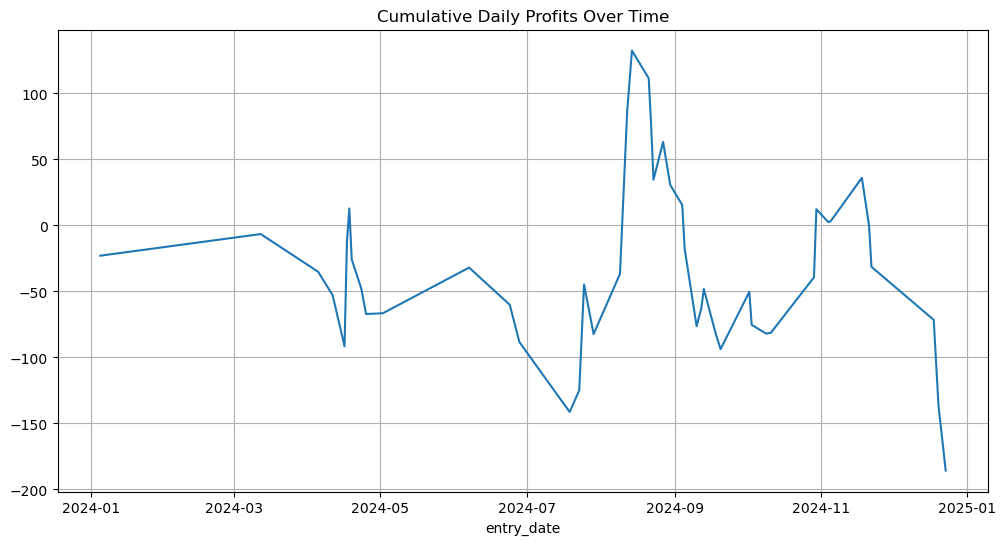

In [163]:
daily_profits.cumsum().plot(figsize=(12, 6), title='Cumulative Daily Profits Over Time', grid=True)

<Axes: title={'center': 'SPY Close Price Over Time'}, xlabel='timestamp'>

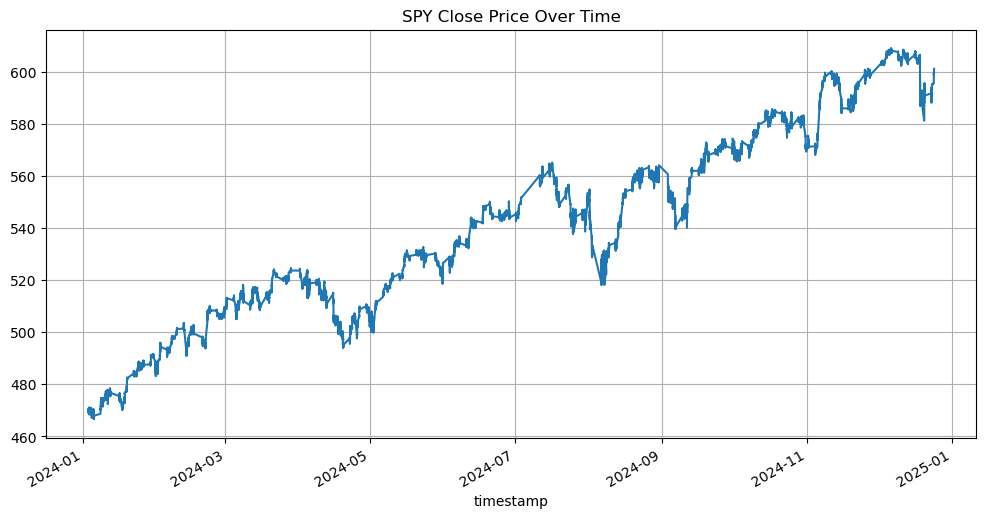

In [77]:
com_df['SPY_close'].plot(figsize=(12, 6), title='SPY Close Price Over Time', grid=True)

In [ ]:
daily_profits